## <b> <center> Detection of Fraud Using Unsupervised Learning </b> </center>

- Author: Derick Malavi
- Email: Malaviderick@gmail.com

### Definition of Business Problem and Value Proposition

<div align='justify'> 
In the insurance industry, fraudulent claims often go undetected due to the <b> lack of clearly labeled data</b>. This case study explores the application of <b> unsupervised learning</b> techniques, such as <b> anomaly detection and clustering</b>, to identify suspicious claim patterns without relying on predefined fraud labels. By uncovering hidden structures in the data, the goal is to support early detection of potentially fraudulent activity and enhance the overall fraud investigation process.
</div>

- We will first load the packages from the python library to facilitate the analysis 

In [6]:
# Load packages 
#--------------------------
# System & Data Handling
#--------------------------
import os
import pandas as pd
import numpy as np
#--------------------------
# Data Visualization
#--------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE 
#--------------------------
# Preprocessing & Feature Engineering
#--------------------------
from sklearn.preprocessing import LabelEncoder, StandardScaler
#--------------------------
# Clustering
# ------------------------------
from sklearn.cluster import KMeans       
from sklearn.cluster import DBSCAN       
from sklearn.decomposition import PCA
# ------------------------------
# Anomally Detection
# ------------------------------
from sklearn.ensemble import IsolationForest  
from sklearn.svm import OneClassSVM
# ------------------------------
# Evaluation
# ------------------------------
from sklearn.metrics import silhouette_score 
# ------------------------------

In [7]:
# Set the path location for our data
path = os.chdir("C:\\Users\\abc\\OneDrive - UGent\\Documenten\\Personal\\CIC_Task_Derick_Malavi")

# Import the data
df = pd.read_csv('insurance_fraud_dataset.csv')

# Clone the dataset
df_copy = df.copy

In [8]:
# We had already checked our data structure and any cases of missing values while perfoming supervised classification. We will therefore briefly recheck a few aspects of the data

In [9]:
df.shape # Check number of rows and columns

(5000, 12)

In [10]:
df.head(5) # Check the first five observations

,Claim_ID,Customer_Age,Policy_Tenure,Claim_Amount,Claim_Type,Previous_Claims,Customer_Income,Marital_Status,Number_of_Dependents,Location,Claim_Submission_Delay,Fraudulent_Claim
0,1,56,10,3466.30,Home,0,58682,Married,3,Suburban,62,0
1,2,69,10,26121.17,Auto,4,140359,Divorced,4,Urban,72,0
2,3,46,4,6659.49,Life,1,175673,Married,2,Urban,64,0
3,4,32,8,48128.70,Home,2,52850,Divorced,0,Suburban,1,0
4,5,60,18,14851.28,Auto,1,61132,Single,1,Rural,1,0


In [11]:
df.dtypes #Check data types

Claim_ID                    int64
Customer_Age                int64
Policy_Tenure               int64
Claim_Amount              float64
Claim_Type                 object
Previous_Claims             int64
Customer_Income             int64
Marital_Status             object
Number_of_Dependents        int64
Location                   object
Claim_Submission_Delay      int64
Fraudulent_Claim            int64
dtype: object

In [12]:
# Get the descriptive summaries of the varaibales 

# Let us first drop the Claim-ID since it will not be informative in our subsequent analysis
df_claim = df.drop('Claim_ID', axis = 1)

In [13]:
df_claim.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Age,5000.0,48.805600,17.906991,18.00,34.0000,49.00,64.0000,79.00
Policy_Tenure,5000.0,10.125000,5.458840,1.00,5.0000,10.00,15.0000,19.00
Claim_Amount,5000.0,25311.709734,14279.862209,509.17,13347.8175,25309.06,37616.5875,49987.19
Previous_Claims,5000.0,1.979200,1.416322,0.00,1.0000,2.00,3.0000,4.00
Customer_Income,5000.0,108676.389800,51908.548381,20178.00,63641.5000,108040.50,153281.5000,199982.00
Number_of_Dependents,5000.0,2.028200,1.413437,0.00,1.0000,2.00,3.0000,4.00
Claim_Submission_Delay,5000.0,43.513200,25.999150,0.00,21.0000,43.00,66.0000,89.00
Fraudulent_Claim,5000.0,0.153400,0.360409,0.00,0.0000,0.00,0.0000,1.00


### Feature Engineering 

<div align='justify'> 
Most unsupervised learning algorithms such as K-Means, Isolation Forest, One-Class SVM work with numerical data input. We therefore need to transform/encode categorical variables such as "Claim Type", "Location", "Marital Status" to avoid introducing bias or misleading patterns.
</div>

In [16]:
# Check uniqueness for each categorical variable
print(df_claim['Claim_Type'].unique()) # Claim type

print(df_claim['Marital_Status'].unique())# Marital status

print(df_claim['Location'].unique()) #Location

['Home' 'Auto' 'Life' 'Medical']
['Married' 'Divorced' 'Single' 'Widowed']
['Suburban' 'Urban' 'Rural']


In [17]:
## One-Hot Encoding 
df_encoded = pd.get_dummies(df_claim, 
                            columns=['Claim_Type', 'Marital_Status', 'Location'],
                            drop_first=True)
df_encoded.head(4)

,Customer_Age,Policy_Tenure,Claim_Amount,Previous_Claims,Customer_Income,Number_of_Dependents,Claim_Submission_Delay,Fraudulent_Claim,Claim_Type_Home,Claim_Type_Life,Claim_Type_Medical,Marital_Status_Married,Marital_Status_Single,Marital_Status_Widowed,Location_Suburban,Location_Urban
0,56,10,3466.30,0,58682,3,62,0,True,False,False,True,False,False,True,False
1,69,10,26121.17,4,140359,4,72,0,False,False,False,False,False,False,False,True
2,46,4,6659.49,1,175673,2,64,0,False,True,False,True,False,False,False,True
3,32,8,48128.70,2,52850,0,1,0,True,False,False,False,False,False,True,False


In [18]:
# Move 'Fraudulent_Claim' to the end
target_col = 'Fraudulent_Claim'

df_encoded = df_encoded[[col for col in df_encoded.columns if col != target_col] + [target_col]]
df_encoded.head(4)

,Customer_Age,Policy_Tenure,Claim_Amount,Previous_Claims,Customer_Income,Number_of_Dependents,Claim_Submission_Delay,Claim_Type_Home,Claim_Type_Life,Claim_Type_Medical,Marital_Status_Married,Marital_Status_Single,Marital_Status_Widowed,Location_Suburban,Location_Urban,Fraudulent_Claim
0,56,10,3466.30,0,58682,3,62,True,False,False,True,False,False,True,False,0
1,69,10,26121.17,4,140359,4,72,False,False,False,False,False,False,False,True,0
2,46,4,6659.49,1,175673,2,64,False,True,False,True,False,False,False,True,0
3,32,8,48128.70,2,52850,0,1,True,False,False,False,False,False,True,False,0


<div align='justify'> 
We have successfully created new variables suitable to be used for unsupervised learning. The categorical features have been transformed into a numerical format using one-hot encoding, making the dataset ready for the next phase of the analysis.
</div>                        

### Data Scaling 

In [21]:
X = df_encoded.drop('Fraudulent_Claim', axis =1)
y = df_encoded['Fraudulent_Claim']

In [22]:
# Scale numerical features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_scaled.head(3)

,Customer_Age,Policy_Tenure,Claim_Amount,Previous_Claims,Customer_Income,Number_of_Dependents,Claim_Submission_Delay,Claim_Type_Home,Claim_Type_Life,Claim_Type_Medical,Marital_Status_Married,Marital_Status_Single,Marital_Status_Widowed,Location_Suburban,Location_Urban
0,0.401805,-0.022901,-1.529958,-1.397562,-0.963221,0.687613,0.711125,1.716488,-0.563800,-0.573039,1.775619,-0.594598,-0.564724,1.395126,-0.698321
1,1.127851,-0.022901,0.056691,1.426937,0.610415,1.395179,1.095792,-0.582585,-0.563800,-0.573039,-0.563184,-0.594598,-0.564724,-0.716781,1.432006
2,-0.156692,-1.122145,-1.306321,-0.691437,1.290795,-0.019953,0.788058,-0.582585,1.773679,-0.573039,1.775619,-0.594598,-0.564724,-0.716781,1.432006


### 1. Dimensionality Reduction (PCA)

#### Why Start with PCA for Visualization
<div align='justify'>
Principal Component Analysis (PCA) helps simplify complex datasets by reducing the number of variables while preserving key patterns. In the context of insurance fraud detection:

- It allows us to **visually explore claim data** in 2D, helping to spot unusual or suspicious patterns early.
- PCA helps uncover **natural groupings or outliers** in the data, which may represent potential fraud cases.
- It provides a clearer foundation for applying unsupervised techniques like clustering or anomaly detection.

Using PCA as a first step enhances **interpretability and business insight**, allowing analysts to focus on what matters most.
</div>

In [25]:
# Apply PCA to reduce dimensions # Let us select 2 PCs
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Convert result to a DataFrame
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2','PC3','PC4','PC5'])

# Include the class labels
df_pca['Fraudulent_Claim'] = y
df_pca.head(3)

,PC1,PC2,PC3,PC4,PC5,Fraudulent_Claim
0,1.224024,-0.082492,-0.254067,-1.872724,-1.717305,0
1,-1.506963,0.209038,-0.147592,0.083270,-0.047804,0
2,-1.390952,2.684135,-0.854266,-0.918081,-0.216761,0


In [26]:
# Explained variance of each principal component
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PC1: {explained_variance[0]:.2f}")
print(f"Explained variance by PC2: {explained_variance[1]:.2f}")
print(f"Explained variance by PC3: {explained_variance[2]:.2f}")
print(f"Explained variance by PC4: {explained_variance[3]:.2f}")
print(f"Explained variance by PC5: {explained_variance[4]:.2f}")

Explained variance by PC1: 0.10
Explained variance by PC2: 0.09
Explained variance by PC3: 0.09
Explained variance by PC4: 0.09
Explained variance by PC5: 0.09


#### PCA Explained Variance
<div align = 'justify'>
The first two principal components (PC1 and PC2) together explain approximately <b> 19% of the total variance</b> in the dataset:
<b>PC1 (10%)</b> captures the largest individual trend or direction of variation.
<b>PC2 (9%)</b> captures the second most significant pattern, orthogonal to PC1.

Although this is a modest portion of the total variability, these components are still valuable for **visualizing the data**, identifying broad **clusters**, and highlighting **potential anomalies**,which may indicate fraudulent claims.
 </div>                                                                                     

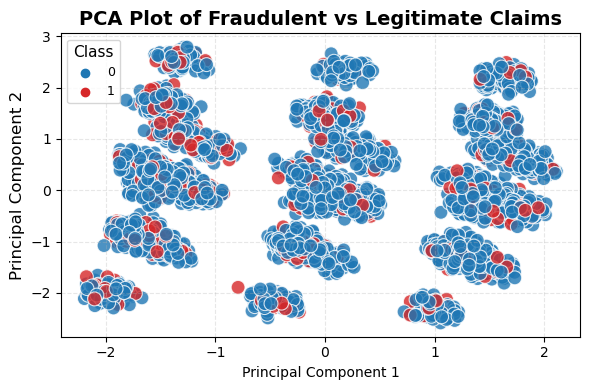

In [28]:
## Plot PCA
plt.figure(figsize=(6, 4))
# Scatterplot
sns.scatterplot(data=df_pca, x='PC1', y='PC2', 
                hue = 'Fraudulent_Claim',
                palette={0: '#1f77b4', 1: '#d62728'}, 
                alpha=0.8, s=100,
               edgecolor='white')
plt.title("PCA Plot of Fraudulent vs Legitimate Claims", fontsize=14, fontweight='bold')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2", fontsize=12)
plt.legend(title="Class", title_fontsize=11, fontsize=9)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

<div align='justify'>
This PCA plot simplifies complex claim data into two dimensions, revealing potential patterns. While fraudulent (blue) and legitimate (red) claims overlap, certain clusters show mild fraud concentration. Though not clearly separable, this supports the need for deeper methods like anomaly detection or clustering to enhance fraud identification.
</div>

### 2.t-distributed Stochastic Neighbor Embedding (t-SNE)

<div align='justify'>
While PCA helps reduce dimensionality and highlight broad trends in the data, it may not fully capture the <b>local relationships between claims</b>,especially in complex fraud patterns.

t-SNE provides a more refined visualization by:
- Mapping high-dimensional data into 2D while preserving **local structure**.
- Revealing **hidden clusters or anomalies** that may correspond to fraudulent claims.
- Helping stakeholders visually understand which claims behave differently from the rest.

This makes t-SNE a valuable tool for **exploratory fraud detection**, complementing PCA with a more intuitive view of how individual claims relate to each other.
</div>

In [32]:
# Apply t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42,init='pca')
X_tsne = tsne.fit_transform(X_scaled)

## In this context, we have only tried one value of perplexity and learning rate. Ideally, several values should be tried to identify which combination gives optimal results.

# Convert to DataFrame for plotting
tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])

# Include the class labels
tsne_df['Fraudulent_Claim'] = y
tsne_df.head(3)

,TSNE1,TSNE2,Fraudulent_Claim
0,-32.202621,28.157885,0
1,-20.050926,-13.094324,0
2,-2.498812,62.590065,0


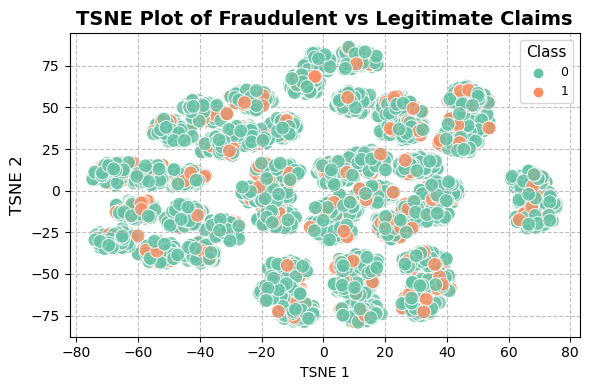

In [33]:
## Plot t-SNE
plt.figure(figsize=(6, 4))
# Scatterplot
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', 
                hue = 'Fraudulent_Claim',
                palette='Set2', 
                alpha=0.8, s=100,
               edgecolor='white')
plt.title("TSNE Plot of Fraudulent vs Legitimate Claims", fontsize=14, fontweight='bold')
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2", fontsize=12)
plt.legend(title="Class", title_fontsize=11, fontsize=9)
plt.grid(True, linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()

<div align='justify'>
- The t-SNE plot reveals how claims group based on similarities across all features. Although there is no clear separation between fraudulent (green) and legitimate (orange) claims, some fraudulent claims cluster together, suggesting shared patterns or behaviors. This should further be investigaeted through clustering. 
</div>

### 3. K-Means Clustering

With only 16 engineered features, applying K-Means directly was feasible and interpretable. However, we first applied PCA and t-SNE for **exploratory visualization**, to better understand the underlying structure and distribution of the data.

- **Dimensionality was already manageable**, so PCA wasn't used for compression but rather for pattern discovery and plotting.
- **Visual cues from t-SNE** suggested natural groupings, supporting the decision to proceed with clustering.
- **K-Means was then applied** on the original scaled features to identify distinct clusters of similar claims, potentially revealing hidden patterns related to fraud.

This approach balances visual understanding with model interpretability, offering practical insights for targeted fraud detection.

In [37]:
# We will first determine the number of clusters with the elbow method 
import warnings
warnings.filterwarnings("ignore")  # Suppresses all warnings

# Compute Within Cluster Sum of Squares (WCSS) for different K values
wcss = []
K_range = range(1, 11)  # Test K from 1 to 10

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X_scaled)
    wcss.append(km.inertia_)  # WCSS (within-cluster sum of squares)

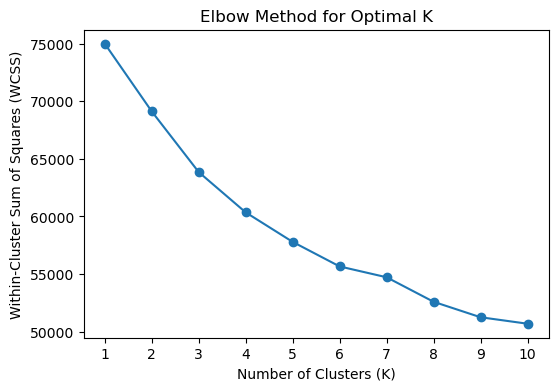

In [38]:
# Plot the Elbow Method
plt.figure(figsize=(6, 4))
plt.plot(K_range, wcss, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal K')
plt.xticks(K_range)
plt.grid(False)
plt.show()

- The elbow point seems to be at three clusters. This is however subjective. We will therefore compute silhoutte scores for different values of k clusters and pick the maximum value. 

In [40]:
# Compute Silhouette Score
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k={k}, Silhouette Score={score:.4f}")

k=2, Silhouette Score=0.0806
k=3, Silhouette Score=0.1053
k=4, Silhouette Score=0.1052
k=5, Silhouette Score=0.0954
k=6, Silhouette Score=0.0963
k=7, Silhouette Score=0.0928
k=8, Silhouette Score=0.0975
k=9, Silhouette Score=0.1044
k=10, Silhouette Score=0.0978


- Even though clustering structure is weak, `k=3` gives the best available separation.
- We will therefore consider profiling the 3 clusters to check for distinct fraud patterns, behaviors, or demographics.

#### Evaluating the quality of the clusters

Clustering algorithms such as K-means produce clusters, but how do we know if these clusters are of good quality? In our case study, we will use `silhouette score` as an evaluation metric to assess the quality of our clusters. 

<div align='justify'>
The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). It ranges from -1 to 1, where a high value indicates that the object is well-matched to its own cluster and poorly matched to neighbouring clusters. A silhouette score close to 1 suggests that the object is appropriately assigned to its cluster, while a score near -1 indicates that it is assigned to the wrong cluster. In clustering, we aim for a high silhouette score, as it indicates well-separated clusters and a clear distinction between them. The silhouette score is computed for each sample and then averaged to obtain an overall score for the clustering.
</div>

In [45]:
silhouette_avg = silhouette_score(X_scaled, km.labels_)
print("\nSilhouette Score:", silhouette_avg)


Silhouette Score: 0.09782366231443379


- The **Silhouette Score** of **0.098** suggests **weak but present structure**, indicating that while the clusters are not highly separated, they still provide meaningful segmentation for exploratory analysis.

In [47]:
# We will therefore fit KMeans with 3 clusters
km = KMeans(n_clusters=3, random_state=42)

# Fit KMeans 
km.fit(X_scaled)

# obtain cluster memberships for each item in the data
y_preds = km.predict(X_scaled)

# Bind the cluster label to PCA and TSNE data frames 
df_pca['cluster_label'] = y_preds
tsne_df['cluster_label'] = y_preds

In [48]:
df_pca.head(3)

,PC1,PC2,PC3,PC4,PC5,Fraudulent_Claim,cluster_label
0,1.224024,-0.082492,-0.254067,-1.872724,-1.717305,0,2
1,-1.506963,0.209038,-0.147592,0.083270,-0.047804,0,0
2,-1.390952,2.684135,-0.854266,-0.918081,-0.216761,0,2


In [49]:
tsne_df.head(3)

,TSNE1,TSNE2,Fraudulent_Claim,cluster_label
0,-32.202621,28.157885,0,2
1,-20.050926,-13.094324,0,0
2,-2.498812,62.590065,0,2


- We will use PCA and TSNE data to visualize the KMeans clusters

In [51]:
# Transform KMeans centroids into PCA 
centroids_pca = pca.transform(km.cluster_centers_)

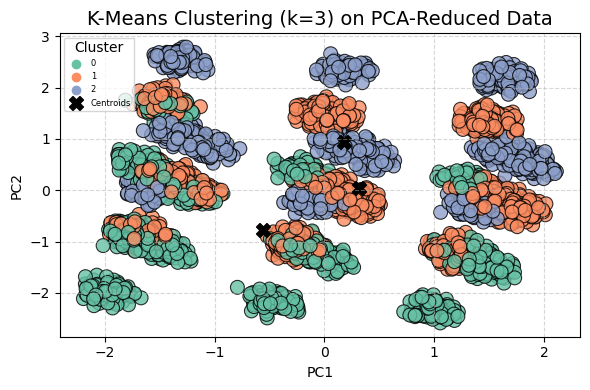

In [52]:
# Plot the clusters based on PCA
plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=df_pca, x='PC1', y='PC2',
    hue='cluster_label', palette='Set2',
    s=100, alpha=0.8, edgecolor='black'
)
# Plot centroids
plt.scatter(
    centroids_pca[:, 0], centroids_pca[:, 1],
    s=100, c='black', marker='X', label='Centroids'
)

plt.title("K-Means Clustering (k=3) on PCA-Reduced Data", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster", loc='best',fontsize=6)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

- Initial PCA visualization indicated overlapping clusters, suggesting linear dimensionality reduction may not fully capture complex structures in the data. To address this, we applied t-distributed Stochastic Neighbor Embedding (t-SNE), a nonlinear technique better suited for identifying subtle, nonlinear patterns and clearer separation among clusters.

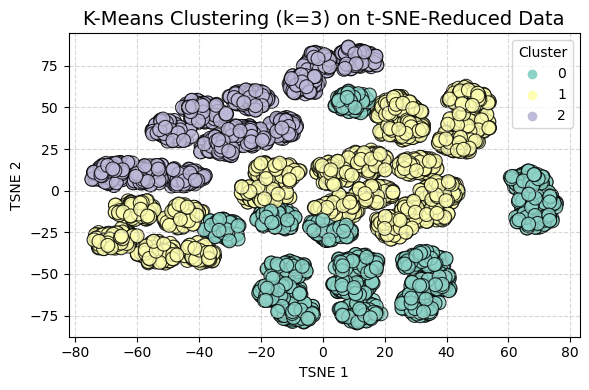

In [54]:
# Plot the clusters based on t-SNE
plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=tsne_df, x='TSNE1', y='TSNE2',
    hue='cluster_label', palette='Set3',
    s=100, alpha=0.8, edgecolor='black'
)
plt.title("K-Means Clustering (k=3) on t-SNE-Reduced Data", fontsize=14)
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.legend(title="Cluster", loc='best')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Applying **K-Means clustering** with *k=3* after **dimensionality reduction using t-SNE** enabled us to visualize and uncover distinct patterns in the insurance claims data. The resulting clusters reveal natural groupings based on similarities in:

- Customer behavior  
- Claim characteristics  
- Submission patterns

While these clusters do not directly correspond to known fraud labels, they offer valuable insights into **anomalous segments** or **groups of interest**.

This approach lays the groundwork for **risk profiling**, where similar claims are grouped together, allowing **suspicious patterns** to be flagged for further investigation.

### 4. Anomaly Detection in Insurance Claims

To complement clustering analysis, we applied **unsupervised anomaly detection techniques** to identify unusual or suspicious claims that may not align with the dominant patterns in the data. These methods help flag potential outliers without relying on prior fraud labels.

#### Methods to be Used:
- **Isolation Forest**  
  Detects anomalies by isolating observations in random decision trees. Anomalies are expected to be isolated faster due to fewer splits needed.  

#### Next Steps:
- Visualize detected anomalies on PCA/t-SNE plots for interpretability.
- Compare overlap with existing cluster groups.
- Investigate flagged records for common characteristics or potential fraud patterns.

#### 4.1. Isolation Forest

In [59]:
# Step 1. Train without labels with contamination at 5%

iso_forest = IsolationForest(contamination=0.05, 
                             n_estimators=100, random_state=42)

# We will fit the model and predict
iso_preds = iso_forest.fit_predict(X_scaled)

# Then convert to binary flag (get predictions): 1 = normal, -1 = anomaly
iso_anomaly_flag = (iso_preds == -1).astype(int)  # 1 = anomaly, 0 = normal

# Compute anomaly score. Lower = more anomolous. We will multiply by -1 to reverse). Therefore higher = more anomolous and lower = more normal
df['anomaly_score'] = -iso_forest.decision_function(X_scaled)

In [60]:
# Step 2. Bind anomaly results back to the original data
df['IsolationForest_Anomaly'] = iso_anomaly_flag
df.head(3)

,Claim_ID,Customer_Age,Policy_Tenure,Claim_Amount,Claim_Type,Previous_Claims,Customer_Income,Marital_Status,Number_of_Dependents,Location,Claim_Submission_Delay,Fraudulent_Claim,anomaly_score,IsolationForest_Anomaly
0,1,56,10,3466.30,Home,0,58682,Married,3,Suburban,62,0,-0.036256,0
1,2,69,10,26121.17,Auto,4,140359,Divorced,4,Urban,72,0,-0.081563,0
2,3,46,4,6659.49,Life,1,175673,Married,2,Urban,64,0,-0.035938,0


In [61]:
# Step 3. Explore anomalies (summary statistics)
# View anomalies
anomalies = df[df['IsolationForest_Anomaly'] == 1]

# Count anomalies
print(f"Number of anomalies detected: {anomalies.shape[0]}")

Number of anomalies detected: 250


In [62]:
# View Top Anomalous Records
# Sort by most anomalous
top_anomalies = df.sort_values(by='anomaly_score', ascending=False).head(10)
top_anomalies

,Claim_ID,Customer_Age,Policy_Tenure,Claim_Amount,Claim_Type,Previous_Claims,Customer_Income,Marital_Status,Number_of_Dependents,Location,Claim_Submission_Delay,Fraudulent_Claim,anomaly_score,IsolationForest_Anomaly
3449,3450,19,3,2540.29,Life,0,86254,Single,0,Urban,81,0,0.032494,1
4443,4444,73,1,44136.45,Life,2,24902,Widowed,0,Urban,58,0,0.030458,1
1017,1018,23,19,7021.32,Home,4,194159,Single,0,Suburban,1,0,0.030197,1
719,720,25,17,48086.06,Home,4,32583,Married,0,Suburban,82,0,0.030164,1
2486,2487,77,1,35782.20,Life,1,24490,Widowed,0,Urban,38,0,0.028673,1
2991,2992,78,16,1596.75,Medical,4,130612,Single,0,Urban,57,0,0.026628,1
2100,2101,79,17,793.45,Medical,0,55241,Single,1,Urban,45,0,0.025898,1
753,754,66,1,31707.18,Medical,4,129828,Single,4,Urban,64,0,0.024439,1
4451,4452,79,13,2688.43,Medical,0,82365,Widowed,0,Urban,18,0,0.023728,1
4981,4982,56,17,8439.01,Life,0,188556,Married,0,Urban,80,0,0.023609,1


In [63]:
# Step 4: Explore anomaly patterns by categorical variables
categorical_fields = ['Claim_Type', 'Marital_Status', 'Location']

for col in categorical_fields:
    print(f"\nAverage Anomaly Score by {col}:")
    print(df.groupby(col)['anomaly_score'].mean().sort_values(ascending=False))


Average Anomaly Score by Claim_Type:
Claim_Type
Medical   -0.025799
Life      -0.033323
Home      -0.034559
Auto      -0.061384
Name: anomaly_score, dtype: float64

Average Anomaly Score by Marital_Status:
Marital_Status
Single     -0.031847
Widowed    -0.032652
Married    -0.032843
Divorced   -0.058156
Name: anomaly_score, dtype: float64

Average Anomaly Score by Location:
Location
Urban      -0.033394
Suburban   -0.035725
Rural      -0.047926
Name: anomaly_score, dtype: float64


- `Auto claims` are most likely to behave `anomalously` compared to other types.
- `Medical` is the least anomalous on average.
- `Divorced` individuals show more irregular patterns in claims compared to single people. 
- Claims from `rural areas` tend to show more anomalous characteristics.

In [65]:
# Step 5. Explore anomalies in numeric variables
# Summary stats for numerical features in anomalies
numerical_cols = [
    'Customer_Age', 'Policy_Tenure', 'Claim_Amount',
    'Customer_Income', 'Claim_Submission_Delay',
    'Number_of_Dependents'
]

for col in numerical_cols:
    print(f"\nAverage Anomaly Score by {col}:")
    print(df.groupby(col)['anomaly_score'].mean().sort_values(ascending=False))


Average Anomaly Score by Customer_Age:
Customer_Age
79   -0.018334
77   -0.023659
19   -0.024483
78   -0.027445
23   -0.029562
        ...   
52   -0.046093
47   -0.046921
46   -0.047203
67   -0.047319
55   -0.048208
Name: anomaly_score, Length: 62, dtype: float64

Average Anomaly Score by Policy_Tenure:
Policy_Tenure
1    -0.025335
2    -0.030399
19   -0.030924
3    -0.032205
18   -0.033526
17   -0.035891
16   -0.036240
4    -0.037230
6    -0.040542
5    -0.040947
7    -0.041210
14   -0.041414
15   -0.042506
10   -0.042778
8    -0.043322
13   -0.045022
12   -0.046237
11   -0.047378
9    -0.047386
Name: anomaly_score, dtype: float64

Average Anomaly Score by Claim_Amount:
Claim_Amount
2540.29     0.032494
44136.45    0.030458
7021.32     0.030197
48086.06    0.030164
35782.20    0.028673
              ...   
40062.29   -0.119713
12589.39   -0.119887
21521.61   -0.122183
18605.69   -0.123209
23847.33   -0.127731
Name: anomaly_score, Length: 4999, dtype: float64

Average Anomaly Score b

`Customer Age`
- Older customers (79, 77) have the least anomalous claims.
- Customers in their 40s and 50s (e.g., age 55 = -0.048) have more anomalous behavior.
- `Takeaway`: Claims from middle-aged customers are potentially more irregular.

`Claim Amount`
- Some very specific amounts (e.g., 23847.33) have extremely high anomaly scores.

`Customer Income`
- Some high-income levels (e.g., 140,788) are associated with the most anomalous scores.
- `Takeaway`: High-income customers might be associated with higher-value or unusual claims, worth investigating further.

`Claim Submission Delay`
- Claims with longer submission delays (e.g., 60, 49, 54 days) have more anomalous scores.
- Quick submissions (1–4 days) seem less anomalous.
- `Takeaway`: Delayed submissions might be a red flag for unusual or manipulated claims.

`Number of Dependents`
- People with 2+ dependents show more anomalies. This could reflect more complex claims or a behavioral pattern worth flagging.

`Combined Insights`
- Claims with long tenure, delayed submission, and high income from customers aged 45–55 appear most anomalous.

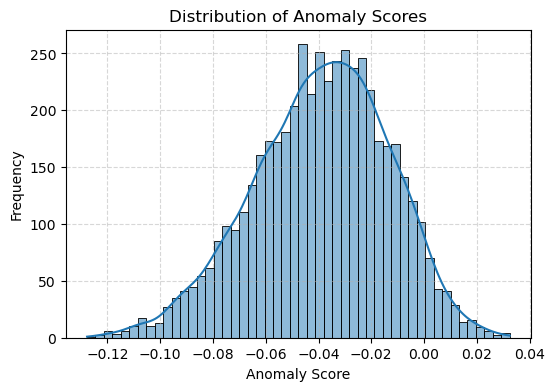

In [68]:
#Step 6. Visualize anomaly score distribution
plt.figure(figsize=(6, 4))
sns.histplot(df['anomaly_score'], bins=50, kde=True)
plt.title("Distribution of Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

From the histogram: 
- The right tail (0.02 to 0.04) = most suspicious claims.
- The left tail (-0.12 to -0.08) = very normal claims.
- The bulk in the middle (~ -0.04 to -0.02) = mostly normal claims with some noise.

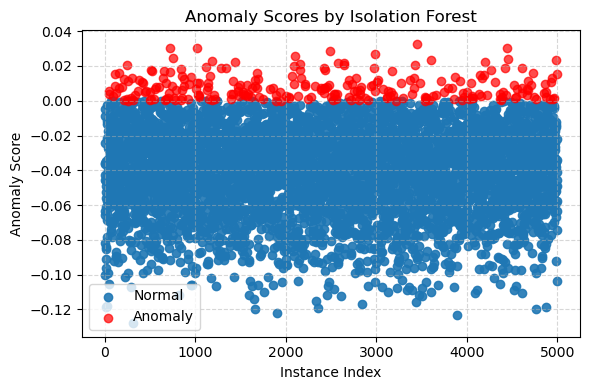

In [70]:
# Scatter Plot ---> Score by Instance

# Split into normal and anomaly instances
normal = df[df['IsolationForest_Anomaly'] == 0]
anomalies = df[df['IsolationForest_Anomaly'] == 1]

# Plot
plt.figure(figsize=(6, 4))
plt.scatter(normal.index, normal['anomaly_score'], label='Normal', alpha=0.9)
plt.scatter(anomalies.index, anomalies['anomaly_score'], label='Anomaly', color='red', alpha=0.7)

plt.xlabel("Instance Index")
plt.ylabel("Anomaly Score")
plt.title("Anomaly Scores by Isolation Forest")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

- The red dots cluster near the top, indicating their anomaly scores are high ---> these are your riskiest records

- The majority of blue dots (normal) are concentrated in the middle and lower range of the score (as expected)

- A few blue points still sit close to the upper range, showing some borderline or "mildly anomalous" claims that weren’t flagged

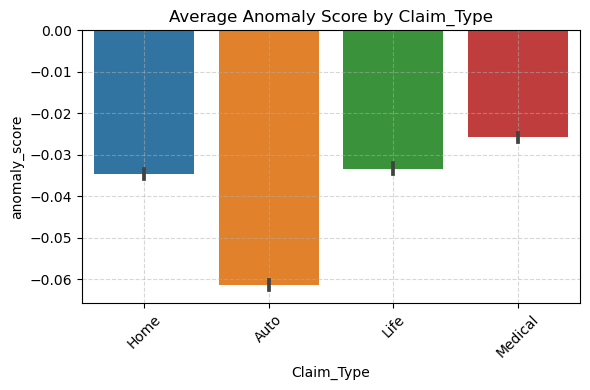

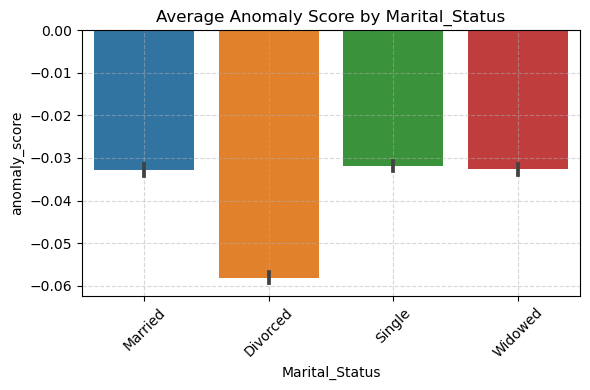

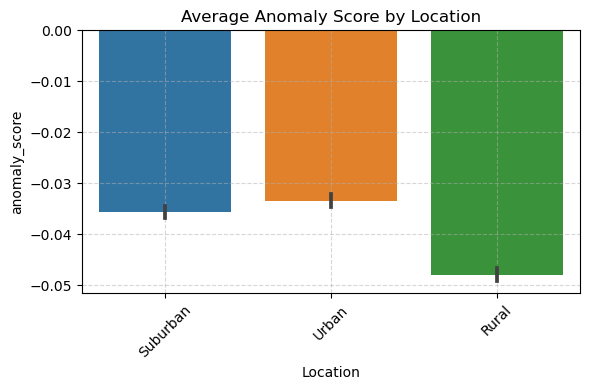

In [72]:
# Step 7. Visualize anomalies by category
for col in categorical_fields:
    plt.figure(figsize=(6, 4))
    sns.barplot(x=col, y='anomaly_score', data=df)
    plt.title(f"Average Anomaly Score by {col}")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [73]:
# Step 8. Investiagate high risk claims

# Custom thresholds. Lets work with top 5% most anomalous
threshold = df['anomaly_score'].quantile(0.95)
df['High_Anomaly'] = (df['anomaly_score'] > threshold).astype(int)

# View high-risk cases
df[df['High_Anomaly'] == 1].head()

,Claim_ID,Customer_Age,Policy_Tenure,Claim_Amount,Claim_Type,Previous_Claims,Customer_Income,Marital_Status,Number_of_Dependents,Location,Claim_Submission_Delay,Fraudulent_Claim,anomaly_score,IsolationForest_Anomaly,High_Anomaly
46,47,79,19,36775.50,Medical,3,192716,Married,4,Suburban,71,0,0.005714,1,1
54,55,20,1,1974.63,Medical,2,48015,Single,2,Urban,24,0,0.003772,1,1
93,94,21,16,5394.23,Medical,0,145113,Married,4,Rural,23,1,0.002958,1,1
114,115,38,1,15629.60,Life,4,58865,Single,0,Suburban,5,1,0.008585,1,1
117,118,35,3,733.27,Home,4,150759,Married,4,Urban,89,0,0.015649,1,1


In [74]:
# Export results for further review
df.to_csv("insurance_claims_with_anomaly_scores.csv", index=False)

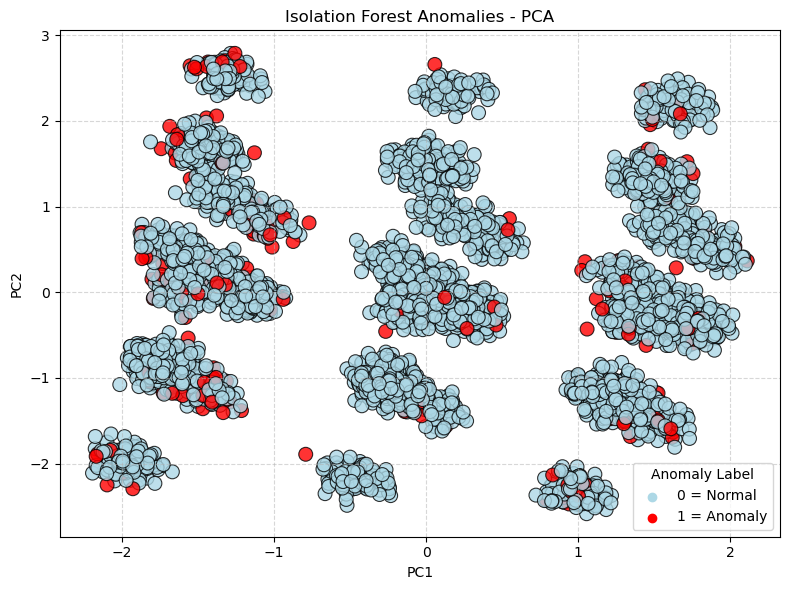

In [75]:
# Visualize with PCA
df_pca['IsolationForest_Anomaly'] = df['IsolationForest_Anomaly']

# Plot
plt.figure(figsize=(8, 6))
plot = sns.scatterplot(  
    data=df_pca, x='PC1', y='PC2',
    hue='IsolationForest_Anomaly',
    palette={0: 'lightblue', 1: 'red'},  
    s=100, alpha=0.8, edgecolor='black'
)
plt.title("Isolation Forest Anomalies - PCA")
plt.legend(title="Anomaly",loc='best',fontsize=6)  
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Relabel legend manually
handles, labels = plot.get_legend_handles_labels()
plot.legend(handles=handles, labels=['0 = Normal', '1 = Anomaly'], title='Anomaly Label')

plt.show()

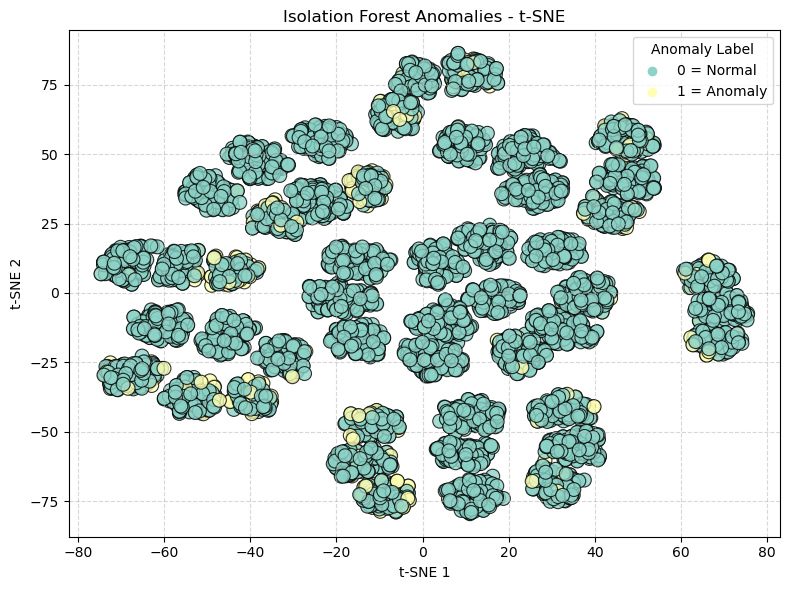

In [76]:
# Visualize with t-SNE
tsne_df['IsolationForest_Anomaly'] = df['IsolationForest_Anomaly']

# Plot
plt.figure(figsize=(8, 6))
plot = sns.scatterplot(
    data=tsne_df, x='TSNE1', y='TSNE2',
    hue='IsolationForest_Anomaly',
    palette='Set3',  
    s=100, alpha=0.8, edgecolor='black'
)

plt.title("Isolation Forest Anomalies - t-SNE")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Manually relabel the legend
handles, labels = plot.get_legend_handles_labels()
plot.legend(handles=handles, labels=['0 = Normal', '1 = Anomaly'], title='Anomaly Label')

plt.show()

 ### 5. Feature Selection 

- **Objective**: Identify which features contribute most to detecting anomalous (potentially fraudulent) claims.

- **Method Used**: Mutual Information (MI) — measures the dependency between each feature and the anomaly labels (0 = Normal, 1 = Anomaly).

In [79]:
from sklearn.feature_selection import mutual_info_classif

feature_names = X_scaled.columns
# X = all features, y = IsolationForest_Anomaly
mi_scores = mutual_info_classif(X_scaled, df['IsolationForest_Anomaly'])
feature_importance = pd.Series(mi_scores, index=feature_names).sort_values(ascending=False)
print(feature_importance)

Number_of_Dependents      0.013592
Claim_Submission_Delay    0.010934
Customer_Income           0.009732
Claim_Amount              0.009584
Location_Urban            0.007599
Previous_Claims           0.007025
Customer_Age              0.005813
Marital_Status_Single     0.005238
Claim_Type_Medical        0.004573
Policy_Tenure             0.004352
Claim_Type_Life           0.002449
Claim_Type_Home           0.000000
Marital_Status_Married    0.000000
Marital_Status_Widowed    0.000000
Location_Suburban         0.000000
dtype: float64


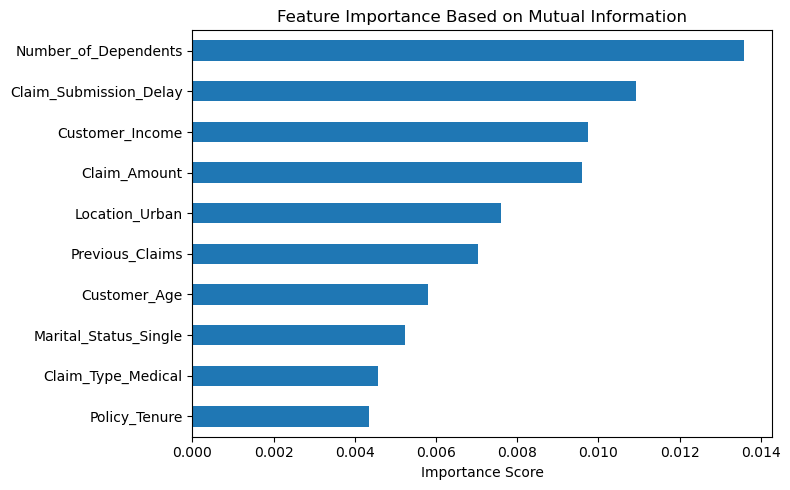

In [80]:
# Plot the feature 

feature_importance[:10].plot(kind='barh', title='Feature Importance Based on Mutual Information', figsize=(8, 5))
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

<div align='justify'>
Using mutual information-based feature selection, we identified that <b>claim submission delay</b>, <b>number of dependents</b>, <b>customer income</b>, and <b>claim amount</b> are the most informative features for detecting anomalous insurance claims. Features such as certain claim types (e.g., Medical) and previous claim history also provide useful signals. Conversely, some categorical attributes, such as Claim_Type_Life, Marital_Status_Married, and Location_Suburban, showed no contribution to anomaly separation.
</div>

## Feature Selection Summary

- **Top Contributing Features**:
  - `Claim_Submission_Delay`: Strongest indicator-delayed claims often appear suspicious.
  - `Number_of_Dependents`: Larger family sizes may correlate with irregular claim patterns.
  - `Customer_Income`: Mismatches between income and claim behavior can signal anomalies.
  - `Claim_Amount`: High or unusual amounts are common in anomaly-prone records.
  - `Claim_Type_Medical` and `Previous_Claims`: Claim type and history also show moderate influence.

- **Low/No Contribution Features**:
  - `Claim_Type_Life`, `Claim_Type_Home`
  - `Marital_Status_Married`, `Marital_Status_Widowed`
  - `Location_Suburban`

These features showed zero mutual information and are unlikely to help differentiate anomalous claims.

- **Next Steps**: Focus modeling and risk rules on the top features; we will consider removing non-informative ones in future iterations.

### Summary of Analysis


This project applied **unsupervised machine learning techniques** to detect and analyze anomalous insurance claims that could potentially indicate fraud.

### Anomaly Detection
- **Isolation Forest** was used to assign anomaly scores to claims.
- Claims with the top 5% highest scores were flagged as anomalies.
- Visualizations (scatter plots, PCA, t-SNE) clearly separated normal and suspicious claims.

### Feature Selection
- **Mutual Information** was used to identify features most strongly linked to anomalies.
- Top contributing features included:
  - `Claim_Submission_Delay`
  - `Number_of_Dependents`
  - `Customer_Income`
  - `Claim_Amount`
- Some categorical features (e.g., `Claim_Type_Life`, `Location_Suburban`) showed no contribution.

### Clustering Analysis
- **K-Means clustering** (k=3) applied after dimensionality reduction (PCA and t-SNE).
- Helped uncover natural groupings among claims based on behavioral similarities.
- Clusters highlighted hidden structures, even among unlabelled data.

###  Business Interpretation
- Anomalies were associated with delayed submissions, high claim amounts, and specific customer profiles (e.g., higher income or dependents).
- Insights can be used to:
  - Improve fraud detection rules
  - Focus manual audits on high-risk segments
  - Enhance future supervised fraud prediction models

---

### Conclusion
Unsupervised methods such as  Isolation Forest, combined with feature selection and clustering, offer valuable tools to identify and profile potentially fraudulent claims, even in the absence of labeled fraud data.